In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [4]:
chexnet_weights="/kaggle/input/fyp2-dataset/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"

In [5]:
train=pd.read_csv("/kaggle/input/dataset8020/impression_train_final8020.csv")
test=pd.read_csv("/kaggle/input/dataset8020/impression_test_final8020.csv")

In [6]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights(chexnet_weights)

chexnet_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [7]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")   

In [8]:
image_folder = "/kaggle/input/fyp2-dataset/NLMCXR_png"
df_path = "/kaggle/input/fyp2-dataset/NLMCXR_reports/NLMCXR_reports/ecgen-radiology"

In [9]:
print(train.shape) 
print(test.shape)

(4404, 6)
(764, 5)


In [10]:
train.head()

Unnamed: 0                             impression  \
0           0  no acute cardiopulmonary abnormality    
1           1                      no acute disease    
2           2  no acute cardiopulmonary abnormality    
3           3  no acute cardiopulmonary abnormality    
4           4  no acute cardiopulmonary abnormality    

                               image_1                              image_2  \
0  NLMCXR_png/CXR2401_IM-0950-1001.png  NLMCXR_png/CXR2401_IM-0950-2001.png   
1   NLMCXR_png/CXR251_IM-1032-1001.png   NLMCXR_png/CXR251_IM-1032-3001.png   
2   NLMCXR_png/CXR211_IM-0740-1001.png   NLMCXR_png/CXR211_IM-0740-1002.png   
3  NLMCXR_png/CXR2391_IM-0944-1001.png  NLMCXR_png/CXR2391_IM-0944-2001.png   
4  NLMCXR_png/CXR1933_IM-0604-1001.png  NLMCXR_png/CXR1933_IM-0604-1002.png   

   impression_counts                                   impression_final  
0                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
1                110                      <SOS> no acute disease  <EOS>  
2                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
3                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
4                411  <SOS> no acute cardiopulmonary abnormality  <EOS>

In [11]:
test.head()

Unnamed: 0                               impression  \
0           0        no acute cardiopulmonary disease    
1           1          no acute pulmonary abnormality    
2           2    no acute cardiopulmonary abnormality    
3           3  no acute cardiopulmonary abnormalities    
4           4        no acute cardiopulmonary process    

                               image_1                              image_2  \
0  NLMCXR_png/CXR3937_IM-2008-1001.png  NLMCXR_png/CXR3937_IM-2008-2001.png   
1   NLMCXR_png/CXR333_IM-1594-1001.png   NLMCXR_png/CXR333_IM-1594-2001.png   
2   NLMCXR_png/CXR529_IM-2137-1001.png   NLMCXR_png/CXR529_IM-2137-2001.png   
3   NLMCXR_png/CXR331_IM-1584-1001.png   NLMCXR_png/CXR331_IM-1584-2001.png   
4  NLMCXR_png/CXR2214_IM-0819-1002.png  NLMCXR_png/CXR2214_IM-0819-1002.png   

   impression_counts  
0                160  
1                 29  
2                411  
3                136  
4                 89

In [12]:
image_1= Input(shape=(224,224,3),name="image_1_features")
image_2= Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)
feature_extraction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_2_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Chexnet_model (Functional)     (None, 1024)         7037504     ['image_1_features[0][0]',       
                                                                  'image_2_features[0][0]'] 

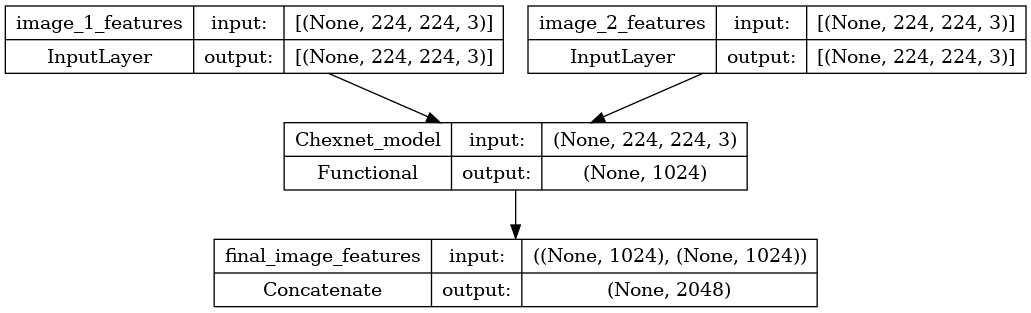

In [13]:
tf.keras.utils.plot_model(feature_extraction_model,show_shapes=True,show_layer_names=True) 

In [14]:
'''
Obtaining the image feature for every patient using the feature extraction model which we had build earlier.
The output from this function is 2048 dimensiona vector for the x-ray set of every patient
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_feature=feature_extraction_model([image_1,image_2])
  
  return image_feature

In [15]:
root_path = "/kaggle/input/fyp2-dataset/NLMCXR_png/"

In [16]:
train_features=np.load("/kaggle/input/chexrayimpressionimgfeature80201dim/train_image_features8020 (1).npz")
train_features=train_features['arr_0']
test_features=np.load("/kaggle/input/chexrayimpressionimgfeature80201dim/test_image_features8020 (1).npz")
test_features=test_features['arr_0']

In [18]:
print(train_features.shape)
print(test_features.shape) 

(4404, 1, 2048)
(764, 1, 2048)


In [17]:
k=100
print(test_features[k])
one=test.iloc[k]["image_1"] 
two=test.iloc[k]["image_2"]

print(image_feature_extraction(root_path+one,root_path+two))  

[[0.         0.00191964 0.0013159  ... 0.81735057 0.8349675  0.6745591 ]]
tf.Tensor([[0.         0.00191964 0.0013159  ... 0.81735057 0.8349675  0.6745591 ]], shape=(1, 2048), dtype=float32)


In [19]:
#Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word

train_report=["<sos> "+text+" <eos>" for text in train["impression"].values]
train_report_in=["<sos> "+text for text in train["impression"].values]
train_report_out=[text+" <eos>" for text in train["impression"].values]

test_report=["<sos> " +text+" <eos>" for text in test["impression"].values]
test_report_in=["<sos> " +text for text in test["impression"].values]
test_report_out=[text+" <eos>" for text in test["impression"].values]  

In [20]:
print(train_report_in[0])
print("*"*100)
print(train_report_out[0])

<sos> no acute cardiopulmonary abnormality 
****************************************************************************************************
no acute cardiopulmonary abnormality  <eos>


In [21]:
bs=20
max_len=22

In [22]:
# tokenizing and padding

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

seq=token.texts_to_sequences(test_report_in)
test_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(test_report_out)
test_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

In [23]:
embeddings_index=dict()
f = open("/kaggle/input/gloveembedding/glove.6B.300d.txt")

In [24]:
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")

Done


In [25]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 1305/1305 [00:00<00:00, 156035.43it/s]


In [26]:
enc_units=512
embedding_dim=300
dec_units=512
att_units=512

In [27]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GRU, AdditiveAttention, Concatenate
from tensorflow.keras.models import Model

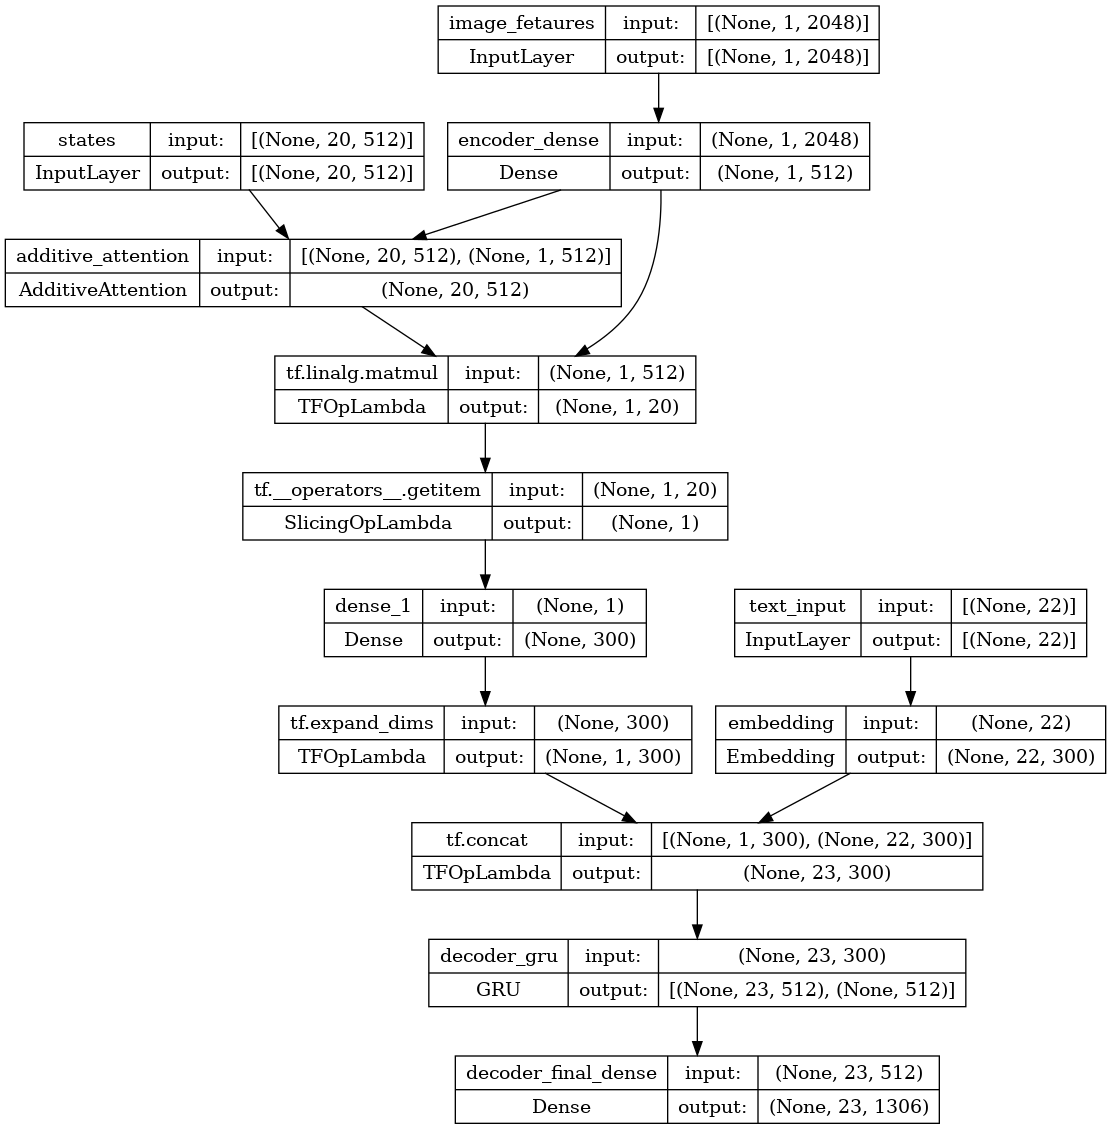

In [28]:
input_img=Input(shape=(1,2048),name="image_fetaures")
input_txt=Input(shape=(max_len),name="text_input")

#encoder model
en_out=Dense(enc_units,activation="relu",name="encoder_dense")(input_img)
enc_out=tf.keras.layers.Dropout(0.2)(en_out)

state_h= Input(shape=(bs,enc_units),name="states")
#decoder model with attention

emb_out=tf.keras.layers.Embedding(vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_txt)
weights=tf.keras.layers.AdditiveAttention()([state_h,en_out])
context_vector=tf.matmul(en_out,weights,transpose_b=True)[:,:,0]
context_vector=Dense(embedding_dim)(context_vector)
result=tf.concat([tf.expand_dims(context_vector, axis=1),emb_out],axis=1)
gru_out,state=tf.keras.layers.GRU(dec_units,return_sequences=True,return_state=True,name="decoder_gru")(result)
out=tf.keras.layers.Dense(vocab_size,name="decoder_final_dense") (gru_out)
en_de=Model(inputs=[input_txt,input_img,state_h],outputs=out)

plot_model(en_de,show_shapes=True, show_layer_names=True)

In [29]:
#encoder model

class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 0),name="encoder_dense")
    self.maxpool=tf.keras.layers.Dropout(0.2)

  def call(self,input_):
    enc_out=self.maxpool(input_)
    enc_out=self.dense1(enc_out) 
    
    return enc_out
    
  def initialize_states(self,batch_size):
      hidden=tf.zeros((batch_size,self.units))
      
      return hidden 

In [30]:
# Attention class

class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):

    super().__init__()
    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):
   
    x=tf.expand_dims(decoder_hidden_state,1)
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
    alphas=tf.nn.softmax(alpha_dash,1)
    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]


    return (context_vector,alphas)
        

In [31]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])

    self.gru=tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform',name="decoder_gru")
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2") 


  def call(self,input_to_decoder, encoder_output, state_h):
    
    embed=self.embedding(input_to_decoder)
    
    context_vector,alpha=self.attention(state_h,encoder_output)
    
    context_vector=self.dense_2(context_vector) 
    
    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
    
   
    output,decoder_state_1=self.gru(result,initial_state=state_h)
    out=tf.reshape(output,(-1,output.shape[-1]))

    out=tf.keras.layers.Dropout(0.2)(out)
    
    dense_op=self.dense(out)
    
    return dense_op,decoder_state_1,alpha

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1):
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

In [33]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
 
  def call(self, data):
        features,report  = data[0], data[1]
        
        encoder_output= self.encoder(features)
        state_h=self.encoder.initialize_states(self.batch_size)
        
        output= self.decoder(report, encoder_output,state_h)
      
        return output

In [35]:
optimizer = tf.keras.optimizers.Adam(1e-3)

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_ 

In [36]:
model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)
model.compile(optimizer=optimizer,loss=loss_function,metrics=['accuracy'])

In [ ]:
model.fit([train_features[:4060],train_padded_inp[:4060]],train_padded_out[:4060],validation_data=([test_features[:760],test_padded_inp[:760]],test_padded_out[:760]), batch_size=bs,epochs=20)

In [ ]:
model.save_weights('/kaggle/working/impression_att_802022512.h5')

In [38]:
model.fit([train_features[:1],train_padded_inp[:1]],train_padded_out[:1],validation_data=([test_features[:1],test_padded_inp[:1]],test_padded_out[:1]), batch_size=bs,epochs=1)

KeyboardInterrupt: 

In [39]:
model.load_weights('/kaggle/input/model2-impression8020512-2/impression_att_802022512.h5')

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Plot the learning curve using the train_loss and val_loss data
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [40]:
def take_second(elem):
    return elem[1]

In [ ]:
import time

In [41]:
def evaluate(image1,image2):
  
  curr=tf.constant([[token.word_index['<sos>']]])
  # curr= np.array([token.word_index['<sos>']]).reshape(1,1)

  features=image_feature_extraction(image1,image2)

  h= tf.zeros((1,enc_units))

  en_output= model.layers[0].predict(features)
  
  pred=[]
  for i in range(max_len):
    out,h,alpha=model.layers[1].onestep(curr,en_output,h)
    
    k=tf.argmax(out[0])

    curr=np.reshape(k,(1,1))
    
    pred.append(token.index_word[curr[0][0]])
    if token.index_word[curr[0][0]]=="<eos>":
      break
 
  predi="<sos> "               
  for j in pred:
    predi+=j+" "
 
  
  return predi

In [42]:
!pip install pycocoevalcap
!pip install rouge
!pip install -U nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 11.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=93512 sha256=76bde76e6c5b5f73e05c52de2170adbb7c41f99c220180d37da24cecb269fb08
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have n

True

In [43]:
from pycocoevalcap.meteor.meteor import Meteor as MeteorCoco
from pycocoevalcap.rouge.rouge import Rouge as RougeCoco
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
import nltk
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

In [44]:
def get_rouge(reference, prediction, variant="rouge-l", measure="f"):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(reference, prediction)
    return rouge_scores[0][variant][measure]

In [45]:
def get_meteor(reference, prediction):
    hypothesis = [reference.split()]
    reference = prediction.split()
    return meteor_score(hypothesis, reference)

In [46]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=72c8b448935eac200d08c6bcc9fb69cd05dcdbf1a3bfd96ddc7d056760c1264e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [47]:
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from rouge_score import scoring
def get_rouge_l(reference, prediction):
    reference_tokens = word_tokenize(reference)
    prediction_tokens = word_tokenize(prediction)
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference_tokens), ' '.join(prediction_tokens))
    rouge_l_fscore = scores['rougeL'].fmeasure
    return rouge_l_fscore

In [48]:
def get_scores(reference,prediction):
    scores = dict()
    for k, v in get_bleu(reference, prediction).items():
        scores[k] = v
    scores["rouge-l"]  = get_rouge(reference, prediction)
    scores["meteor"] = get_meteor(reference, prediction);
    # vale, arr = get_cider(query, groundtruth)
    return scores

In [49]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = bleu.sentence_bleu(reference,prediction,weights = (1,0,0,0))
  bleu2 = bleu.sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = bleu.sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = bleu.sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [50]:
root_path = "/kaggle/input/fyp2-dataset/NLMCXR_png/"

In [51]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [52]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [53]:
import random 
index=range(0,test.shape[0])
b1=0
b2=0
b3=0
b4=0
rouge_all = 0
meteor_all = 0
rouge_l_all=0

blue_top_five = []
blue_min_five = []

rouge_top_five = []
rouge_min_five = []

rouge_l_top_five = []
rouge_l_min_five = []

meteor_top_five = []
meteor_min_five = []

results=[]
start1=time.time()
for i in index:
  print(i)
  img1=root_path+test.iloc[i]["image_1"]
  img2=root_path+test.iloc[i]["image_2"]
  
  result=evaluate(img1,img2) 
  actual=test_report[i]
  img_blue = get_bleu(actual,result)
  rouge = get_rouge(actual,result)
  meteor = get_meteor(actual,result)
  rouge_l = get_rouge_l(actual,result)

  b1+=img_blue[0]
  b2+=img_blue[1]
  b3+=img_blue[2]
  b4+=img_blue[3]

  rouge_all += rouge
  rouge_l_all += rouge_l
  meteor_all += meteor
  
  results.append({
    'Index':i,
    'Image1': img1,
    'Image2': img2,
    'Result': result,
    'Actual': actual,
    'BLEU1': b1,
    'BLEU2': b2,
    'BLEU3': b3,
    'BLEU4': b4,
    'ROUGE': rouge,
    'METEOR': meteor,
    'ROUGE-L': rouge_l
    })
  if len(blue_top_five) < 5:
      blue_top_five.append({"img_blue": img_blue, "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      blue_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
      rouge_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      rouge_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
      rouge_l_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      rouge_l_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      

      meteor_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      meteor_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
  else:
    if img_blue[3] > min(entry["img_blue"][3] for entry in blue_top_five):
        min_index = min(range(len(blue_top_five)), key=lambda i: blue_top_five[i]["img_blue"][3])
        blue_top_five.pop(min_index)
        blue_top_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l ,"meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if img_blue[3] < max(entry["img_blue"][3] for entry in blue_min_five):
        max_index = max(range(len(blue_top_five)), key=lambda i: blue_min_five[i]["img_blue"][3])
        blue_min_five.pop(max_index)
        blue_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l ,"meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

    if rouge > min(entry["rouge"] for entry in rouge_top_five):
        min_index = min(range(len(rouge_top_five)), key=lambda i: rouge_top_five[i]["rouge"])
        rouge_top_five.pop(min_index)
        rouge_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if rouge < max(entry["rouge"] for entry in rouge_min_five):
        max_index = max(range(len(rouge_top_five)), key=lambda i: rouge_min_five[i]["rouge"])
        rouge_min_five.pop(max_index)
        rouge_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

    if rouge_l > min(entry["rouge_l"] for entry in rouge_l_top_five):
        min_index = min(range(len(rouge_l_top_five)), key=lambda i: rouge_l_top_five[i]["rouge_l"])
        rouge_l_top_five.pop(min_index)
        rouge_l_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if rouge_l < max(entry["rouge_l"] for entry in rouge_l_min_five):
        max_index = max(range(len(rouge_l_top_five)), key=lambda i: rouge_l_min_five[i]["rouge_l"])
        rouge_l_min_five.pop(max_index)
        rouge_l_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})




    if meteor > min(entry["meteor"] for entry in meteor_top_five):
        min_index = min(range(len(meteor_top_five)), key=lambda i: meteor_top_five[i]["meteor"])
        meteor_top_five.pop(min_index)
        meteor_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if meteor < max(entry["meteor"] for entry in meteor_min_five):
        max_index = max(range(len(meteor_top_five)), key=lambda i: meteor_min_five[i]["meteor"])
        meteor_min_five.pop(max_index)
        meteor_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

end1=time.time() 
print("average bleu score on the test data is ",b1/test.shape[0],b2/test.shape[0],b3/test.shape[0],b4/test.shape[0])
print("average rouge score on the test data is ",rouge_all/test.shape[0])
print("average rouge_l score on the test data is ",rouge_l_all/test.shape[0])
print("average meteor score on the test data is ",meteor_all/test.shape[0])

print('the average time taken for the evaluation is ',(end1-start1)/test.shape[0])

df = pd.DataFrame(results)
df.to_csv('/kaggle/working/results.csv')

0
1/1 [==============================] - 0s 133ms/step
1
1/1 [==============================] - 0s 19ms/step
2
1/1 [==============================] - 0s 22ms/step
3
1/1 [==============================] - 0s 19ms/step
4
1/1 [==============================] - 0s 19ms/step
5
1/1 [==============================] - 0s 20ms/step
6
1/1 [==============================] - 0s 22ms/step
7
1/1 [==============================] - 0s 19ms/step
8
1/1 [==============================] - 0s 21ms/step
9
1/1 [==============================] - 0s 32ms/step
10
1/1 [==============================] - 0s 20ms/step
11
1/1 [==============================] - 0s 25ms/step
12
1/1 [==============================] - 0s 23ms/step
13
1/1 [==============================] - 0s 21ms/step
14
1/1 [==============================] - 0s 18ms/step
15
1/1 [==============================] - 0s 20ms/step
16
1/1 [==============================] - 0s 22ms/step
17
1/1 [==============================] - 0s 20ms/step
18
1/1 [===========

In [54]:
blue_top_five = sorted(blue_top_five, key=lambda x: x['img_blue'][3], reverse=True)
blue_min_five = sorted(blue_min_five, key=lambda x: x['img_blue'][3], reverse=False)

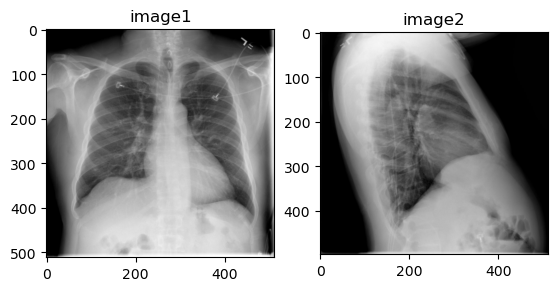

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1776_IM-0508-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1776_IM-0508-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


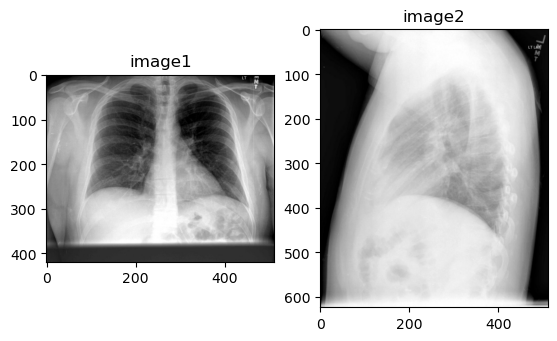

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR731_IM-2291-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR731_IM-2291-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


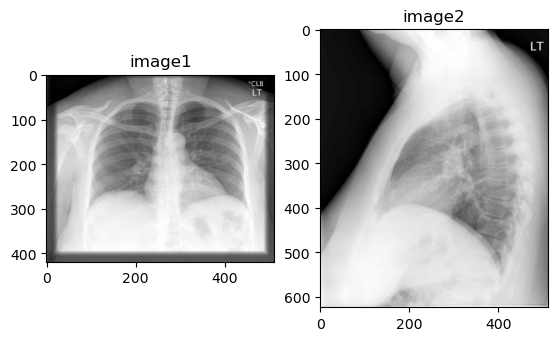

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3429_IM-1657-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3429_IM-1657-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


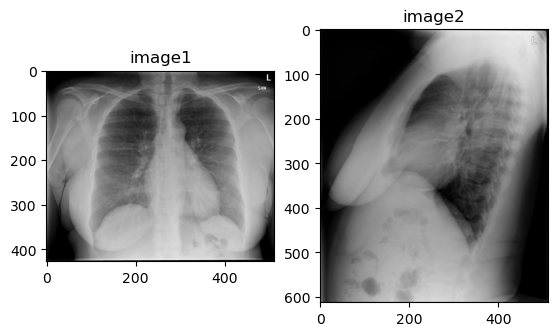

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR909_IM-2414-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR909_IM-2414-1002.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


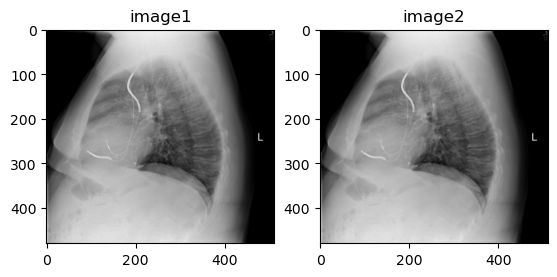

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1830_IM-0537-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1830_IM-0537-2001.png
blue:  (0.4444444444444444, 0.6666666666666666, 0.7652084708603571, 0.816496580927726)
rouge:  0.5714285665306124
rouge_l:  0.5333333333333333
meteor:  0.3174603174603175
ACTUAL REPORT:  <sos> negative for acute abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality no fracture visualized <eos> 
****************************************************************************************************


In [55]:
for i in range(5):
    i1 = cv2.imread(blue_top_five[i]["img1"])
    i2 = cv2.imread(blue_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", blue_top_five[i]["img1"]) 
    print("img2: ", blue_top_five[i]["img2"]) 

    print("blue: ", blue_top_five[i]["img_blue"]) 
    print("rouge: ", blue_top_five[i]["rouge"]) 
    print("rouge_l: ", blue_top_five[i]["rouge_l"]) 
    print("meteor: ", blue_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", blue_top_five[i]["actual"])
    print("GENERATED REPORT: ", blue_top_five[i]["generated"])
    print("*"*100)

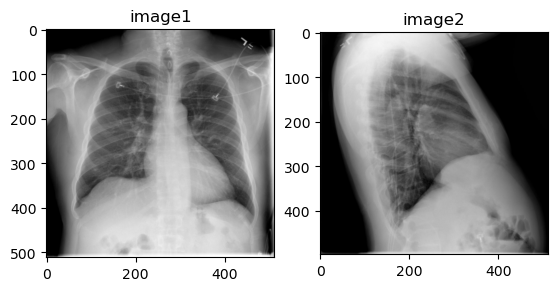

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1776_IM-0508-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1776_IM-0508-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


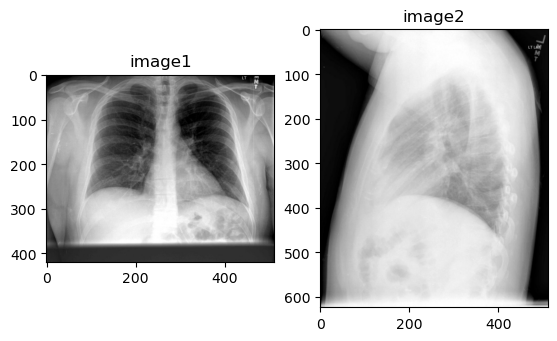

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR731_IM-2291-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR731_IM-2291-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


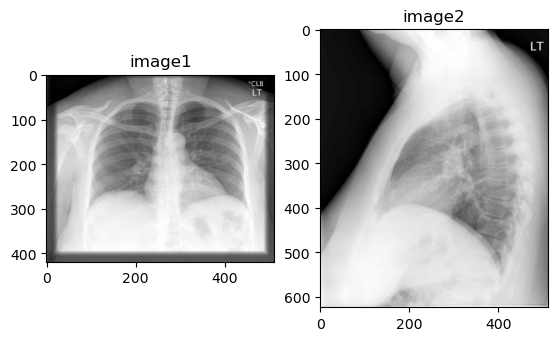

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3429_IM-1657-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3429_IM-1657-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


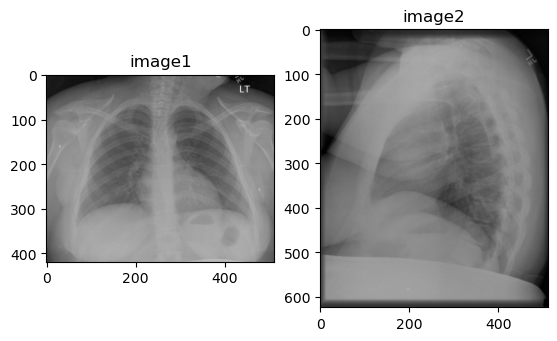

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1597_IM-0388-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1597_IM-0388-2001.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.5034777750283593, 0.5946035575013605)
rouge:  0.9090909041322315
rouge_l:  0.9090909090909091
meteor:  0.9490196078431373
ACTUAL REPORT:  <sos> no acute abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


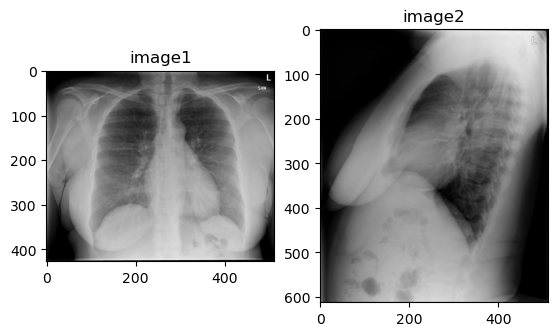

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR909_IM-2414-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR909_IM-2414-1002.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


In [56]:
for i in range(5):
    i1 = cv2.imread(rouge_top_five[i]["img1"])
    i2 = cv2.imread(rouge_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", rouge_top_five[i]["img1"]) 
    print("img2: ", rouge_top_five[i]["img2"]) 
    print("blue: ", rouge_top_five[i]["img_blue"]) 
    print("rouge: ", rouge_top_five[i]["rouge"]) 
    print("rouge_l: ", rouge_top_five[i]["rouge_l"]) 
    print("meteor: ", rouge_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", rouge_top_five[i]["actual"])
    print("GENERATED REPORT: ", rouge_top_five[i]["generated"])
    print("*"*100)

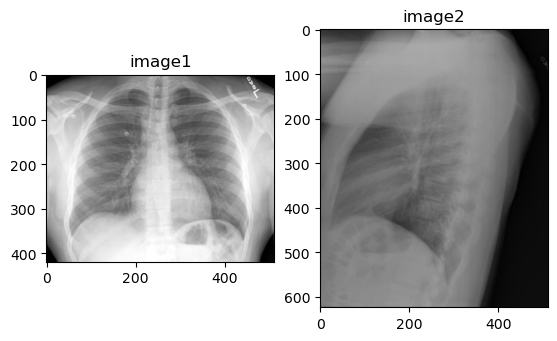

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-2001.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.63287829698514, 0.537284965911771)
rouge:  0.8333333283333335
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


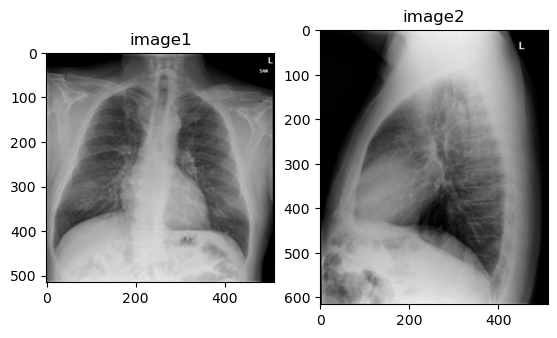

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2378_IM-0938-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2378_IM-0938-1002.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.63287829698514, 0.537284965911771)
rouge:  0.8333333283333335
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


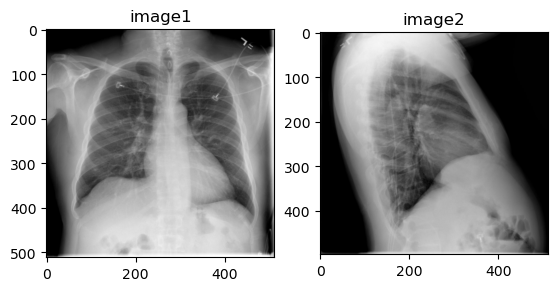

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1776_IM-0508-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1776_IM-0508-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


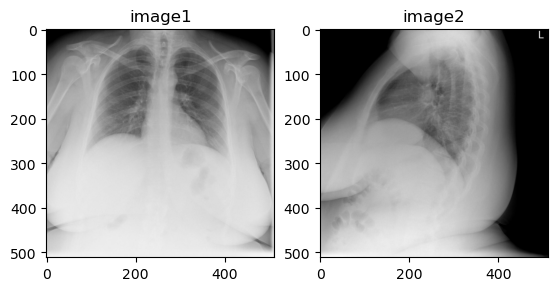

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-2001.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.63287829698514, 0.537284965911771)
rouge:  0.8333333283333335
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


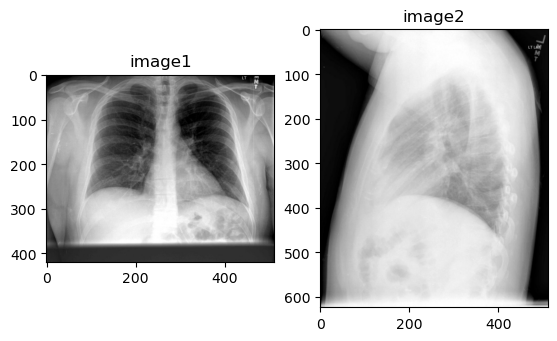

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR731_IM-2291-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR731_IM-2291-2001.png
blue:  (1.0, 1.0, 1.0, 1.0)
rouge:  0.999999995
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


In [57]:
for i in range(5):
    i1 = cv2.imread(meteor_top_five[i]["img1"])
    i2 = cv2.imread(meteor_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", meteor_top_five[i]["img1"]) 
    print("img2: ", meteor_top_five[i]["img2"]) 
    print("blue: ", meteor_top_five[i]["img_blue"]) 
    print("rouge: ", meteor_top_five[i]["rouge"]) 
    print("rouge_l: ", meteor_top_five[i]["rouge_l"]) 
    print("meteor: ", meteor_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", meteor_top_five[i]["actual"])
    print("GENERATED REPORT: ", meteor_top_five[i]["generated"])
    print("*"*100)

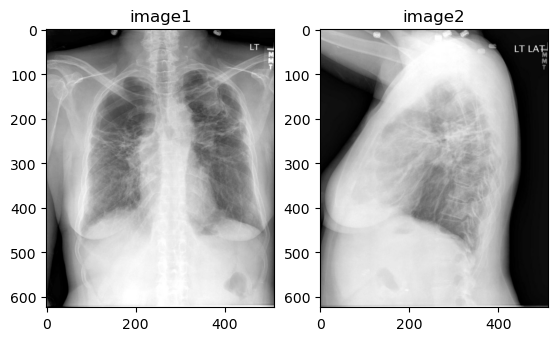

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR382_IM-1927-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR382_IM-1927-2001.png
blue:  (0.0005326307916319118, 0.0006150290618547355, 0.000645855293006029, 0.00066089173706674)
rouge:  0.17142856940408163
rouge_l:  0.16216216216216214
meteor:  0.04983388704318937
ACTUAL REPORT:  <sos> marked bullous emphysematous changes and traction bronchiectasis again most notable involving the bilateral upper lobes stable suspected superimposed left upper lobe aspergilloma more readily demonstrated the previous ct chest study from  <eos>
GENERATED REPORT:  <sos> bilateral effusions <eos> 
****************************************************************************************************


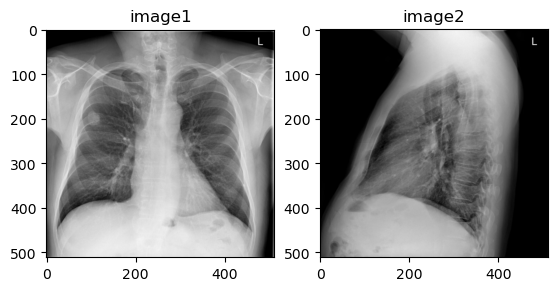

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1944_IM-0613-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1944_IM-0613-2001.png
blue:  (0.00240013304116337, 0.0011384830646254378, 0.0017916294738802652, 0.002217773540373859)
rouge:  0.15624999758300784
rouge_l:  0.1492537313432836
meteor:  0.07005649717514126
ACTUAL REPORT:  <sos> calcific density measuring approximately projecting over right upper lung seen well view only this may represent residua healed rib fracture possibly osteocartilaginous lesion conceivably granuloma which difficult see the lateral view this could followed months confirm stability azygos fissure incidentally noted lungs overall well expanded and clear mediastinal contour normal limits no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  <sos> no evidence acute cardiopulmonary process interval cabg <eos> 
****************************************************************************************************


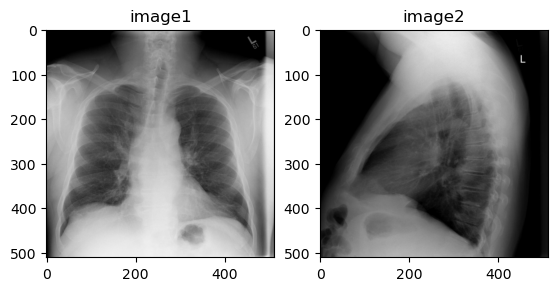

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1783_IM-0511-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1783_IM-0511-3001.png
blue:  (0.0020433857192320333, 0.002889783797297443, 0.0032511757800657345, 0.0034365514525656997)
rouge:  0.13953488131963226
rouge_l:  0.13333333333333336
meteor:  0.04201680672268908
ACTUAL REPORT:  <sos> mild hyperinflation scattered chronic appearing irregular interstitial markings with no focal alveolar consolidation no definite pleural effusion seen heart size near top normal limits aortic ectasia tortuosity similar prior right hemidiaphragm eventration no typical findings pulmonary edema  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


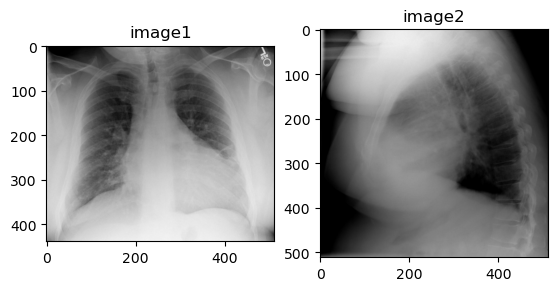

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2975_IM-1364-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2975_IM-1364-2001.png
blue:  (0.0020433857192320333, 0.002889783797297443, 0.0032511757800657345, 0.0034365514525656997)
rouge:  0.14285714040816327
rouge_l:  0.17777777777777778
meteor:  0.056022408963585436
ACTUAL REPORT:  <sos> moderate enlargement the heart this shows significant interval increase size from the remote comparison cardiomegaly pericardial fluid could have this appearance minimal patchy infiltrate atelectasis medial right base and lingular scarring subsegmental atelectasis no pleural effusion pneumothorax  <eos>
GENERATED REPORT:  <sos> cardiomegaly without lung infiltrates <eos> 
****************************************************************************************************


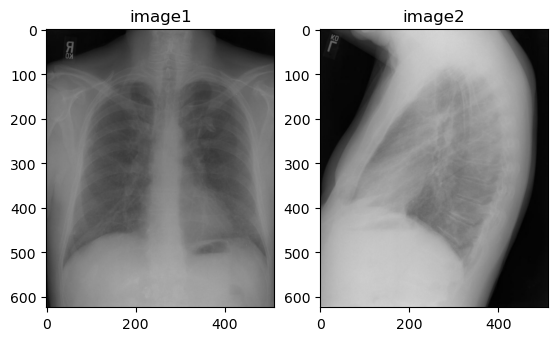

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3934_IM-2005-0001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3934_IM-2005-2001.png
blue:  (0.003743303888380815, 0.001775604939217212, 0.002794267426468536, 0.0034588917259376515)
rouge:  0.15094339366322537
rouge_l:  0.15873015873015875
meteor:  0.07515151515151515
ACTUAL REPORT:  <sos> normal heart size no pleural effusions there appears generalized mild interstitial changes both lungs similar changes appear have been present scan focused the abdomen for more detailed evaluation the lung parenchyma consider with high resolution technique there are no acute airspace disease no lung masses visualized visualized bony structures have normal appearance  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality no evidence tuberculosis <eos> 
****************************************************************************************************


In [58]:
for i in range(5):
    i1 = cv2.imread(blue_min_five[i]["img1"])
    i2 = cv2.imread(blue_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", blue_min_five[i]["img1"]) 
    print("img2: ", blue_min_five[i]["img2"]) 
    print("blue: ", blue_min_five[i]["img_blue"]) 
    
    print("rouge: ", blue_min_five[i]["rouge"]) 
    print("rouge_l: ", blue_min_five[i]["rouge_l"]) 
    print("meteor: ", blue_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", blue_min_five[i]["actual"])
    print("GENERATED REPORT: ", blue_min_five[i]["generated"])


    print("*"*100)

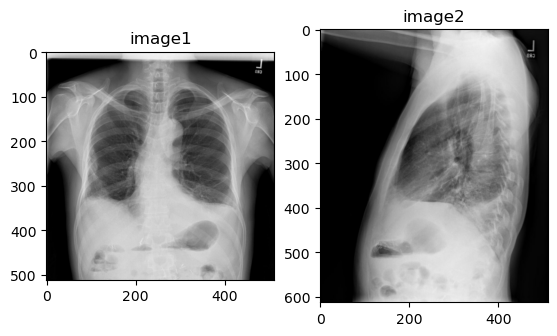

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3396_IM-1640-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3396_IM-1640-3001.png
blue:  (0.03421494292998488, 0.08380915175690977, 0.11365201963583742, 0.13116841108376154)
rouge:  0.09999999580000019
rouge_l:  0.09302325581395349
meteor:  0.03436426116838488
ACTUAL REPORT:  <sos> compared there left subpulmonic pleural effusion which better appreciated there stable right basilar scarring without focal acute infiltrate no pneumothorax cardiomediastinal silhouette stable there are postsurgical changes the abdomen  <eos>
GENERATED REPORT:  <sos> low lung volumes with subsequent bronchovascular crowding and bibasilar atelectasis <eos> 
****************************************************************************************************


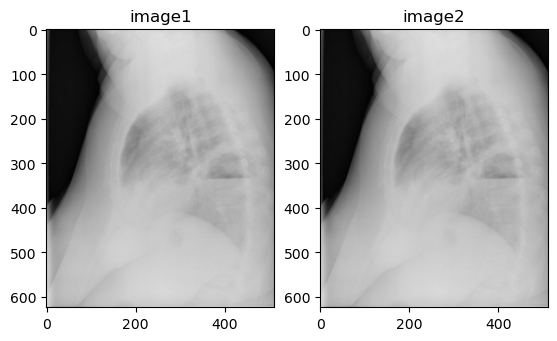

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
blue:  (0.02005176874456075, 0.04483711798194346, 0.0589471198261519, 0.06704712972777122)
rouge:  0.10256409875082198
rouge_l:  0.0930232558139535
meteor:  0.03257328990228013
ACTUAL REPORT:  <sos> airspace disease within the superior segment the right lower lobe with moderate layering right pleural effusion with air fluid level follow resolution cross sectional imaging the chest recommended rule out malignancy  <eos>
GENERATED REPORT:  <sos> stable cardiomegaly without gross evidence for failure pneumonia <eos> 
****************************************************************************************************


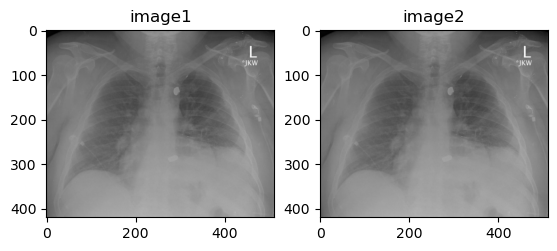

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1493_IM-0318-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1493_IM-0318-1001.png
blue:  (0.022160631672466777, 0.04955267884397056, 0.06514664253618349, 0.07409853791557794)
rouge:  0.09999999625000015
rouge_l:  0.09523809523809523
meteor:  0.03355704697986577
ACTUAL REPORT:  <sos> stable chest elevated left diaphragm two bullets overlie the left chest heart size normal persistent right midlung nodule without definite calcification ct scan may informative patient high for lung cancer  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality postsurgical changes described above <eos> 
****************************************************************************************************


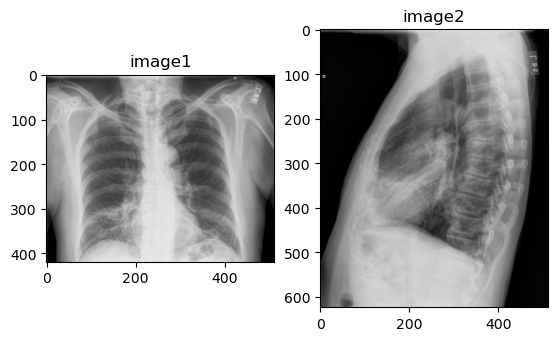

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-3003.png
blue:  (0.009693551957930502, 0.019387103915861004, 0.024539354619488103, 0.027417505292947175)
rouge:  0.10256409930309017
rouge_l:  0.09523809523809523
meteor:  0.03184713375796178
ACTUAL REPORT:  <sos> hyperexpanded lungs suggesting emphysema patchy right middle lobe airspace disease may represent pneumonia followup examination suggested following treatment confirm clearing the opacities post treatment interval film would reasonable allow clearing inflammatory opacities  <eos>
GENERATED REPORT:  <sos> no acute changes from prior imaging <eos> 
****************************************************************************************************


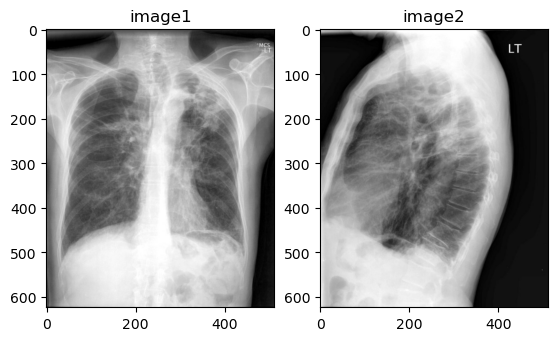

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR4_IM-2050-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR4_IM-2050-2001.png
blue:  (0.011004644011281447, 0.02460713207741128, 0.03235086527482105, 0.036796244961306554)
rouge:  0.088888885688889
rouge_l:  0.0816326530612245
meteor:  0.027700831024930744
ACTUAL REPORT:  <sos> bullous emphysema and interstitial fibrosis probably scarring the left apex although difficult exclude cavitary lesion opacities the bilateral upper lobes could represent scarring however the absence comparison exam recommend short interval followup radiograph ct thorax document resolution  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [59]:
for i in range(5):
    i1 = cv2.imread(rouge_min_five[i]["img1"])
    i2 = cv2.imread(rouge_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", rouge_min_five[i]["img1"]) 
    print("img2: ", rouge_min_five[i]["img2"]) 
    print("blue: ", rouge_min_five[i]["img_blue"]) 
    
    print("rouge: ", rouge_min_five[i]["rouge"]) 
    print("rouge_l: ", rouge_min_five[i]["rouge_l"]) 
    print("meteor: ", rouge_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", rouge_min_five[i]["actual"])
    print("GENERATED REPORT: ", rouge_min_five[i]["generated"])


    print("*"*100)

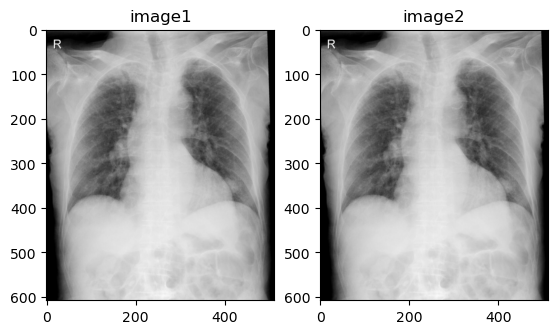

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR206_IM-0697-6001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR206_IM-0697-6001.png
blue:  (0.010535960877319096, 0.021071921754638193, 0.026671923908559082, 0.029800197530674002)
rouge:  0.11764705522491362
rouge_l:  0.0967741935483871
meteor:  0.032467532467532464
ACTUAL REPORT:  <sos> chest left lower lobe nodule which worrisome there are no prior films available for comparison scan for further evaluation pelvis and left hip rotated subcapital fracture left hip femur no fracture the remaining portions the femur left knee normal for age was called and informed these critical results  <eos>
GENERATED REPORT:  <sos> low lung volumes with minimal left basilar atelectasis versus scarring <eos> 
****************************************************************************************************


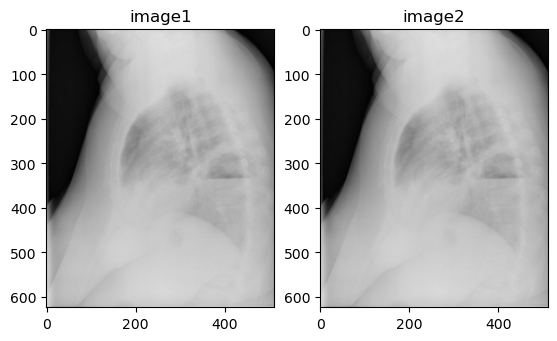

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
blue:  (0.02005176874456075, 0.04483711798194346, 0.0589471198261519, 0.06704712972777122)
rouge:  0.10256409875082198
rouge_l:  0.0930232558139535
meteor:  0.03257328990228013
ACTUAL REPORT:  <sos> airspace disease within the superior segment the right lower lobe with moderate layering right pleural effusion with air fluid level follow resolution cross sectional imaging the chest recommended rule out malignancy  <eos>
GENERATED REPORT:  <sos> stable cardiomegaly without gross evidence for failure pneumonia <eos> 
****************************************************************************************************


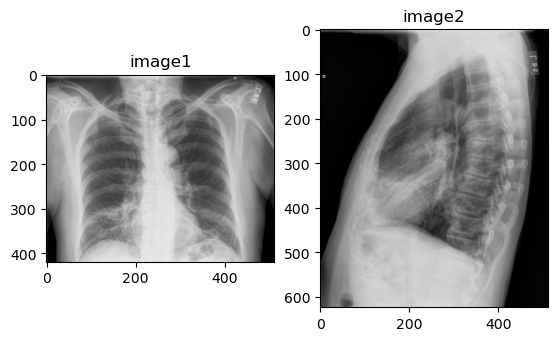

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-3003.png
blue:  (0.009693551957930502, 0.019387103915861004, 0.024539354619488103, 0.027417505292947175)
rouge:  0.10256409930309017
rouge_l:  0.09523809523809523
meteor:  0.03184713375796178
ACTUAL REPORT:  <sos> hyperexpanded lungs suggesting emphysema patchy right middle lobe airspace disease may represent pneumonia followup examination suggested following treatment confirm clearing the opacities post treatment interval film would reasonable allow clearing inflammatory opacities  <eos>
GENERATED REPORT:  <sos> no acute changes from prior imaging <eos> 
****************************************************************************************************


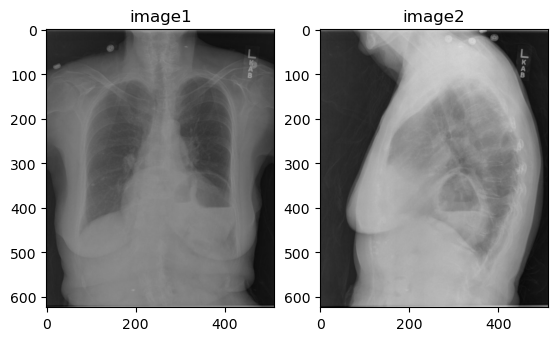

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3192_IM-1505-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3192_IM-1505-2001.png
blue:  (0.02694819387954912, 0.06319911663570724, 0.08444475211904678, 0.09678357951963763)
rouge:  0.10526315378116359
rouge_l:  0.09090909090909091
meteor:  0.033444816053511704
ACTUAL REPORT:  <sos> increased left hilar fullness this may represent superimposed adenopathy cannot excluded this exam there clinical concern suggest reference prior exam ct chest large hiatal hernia increased size from prior exam  <eos>
GENERATED REPORT:  <sos> no acute pulmonary disease multiple thoracic deformities due osteoporosis <eos> 
****************************************************************************************************


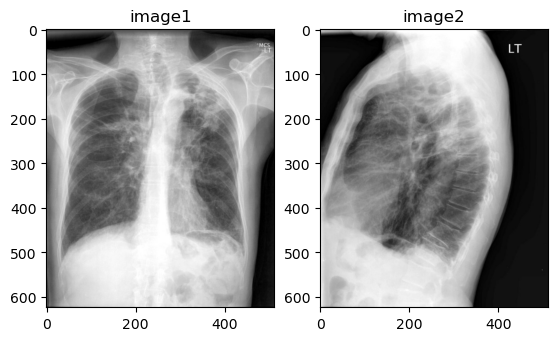

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR4_IM-2050-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR4_IM-2050-2001.png
blue:  (0.011004644011281447, 0.02460713207741128, 0.03235086527482105, 0.036796244961306554)
rouge:  0.088888885688889
rouge_l:  0.0816326530612245
meteor:  0.027700831024930744
ACTUAL REPORT:  <sos> bullous emphysema and interstitial fibrosis probably scarring the left apex although difficult exclude cavitary lesion opacities the bilateral upper lobes could represent scarring however the absence comparison exam recommend short interval followup radiograph ct thorax document resolution  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [60]:
for i in range(5):
    i1 = cv2.imread(meteor_min_five[i]["img1"])
    i2 = cv2.imread(meteor_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", meteor_min_five[i]["img1"]) 
    print("img2: ", meteor_min_five[i]["img2"]) 
    print("blue: ", meteor_min_five[i]["img_blue"]) 
    
    print("rouge: ", meteor_min_five[i]["rouge"]) 
    print("rouge_l: ", meteor_min_five[i]["rouge_l"]) 
    print("meteor: ", meteor_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", meteor_min_five[i]["actual"])
    print("GENERATED REPORT: ", meteor_min_five[i]["generated"])


    print("*"*100)

1/1 [==============================] - 0s 25ms/step


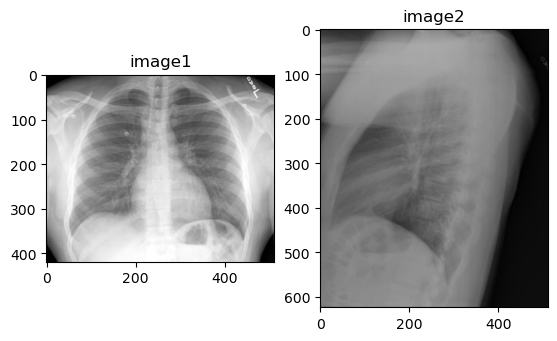

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-2001.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.63287829698514, 0.537284965911771)
rouge:  0.8333333283333335
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


In [61]:
i=3
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 25ms/step


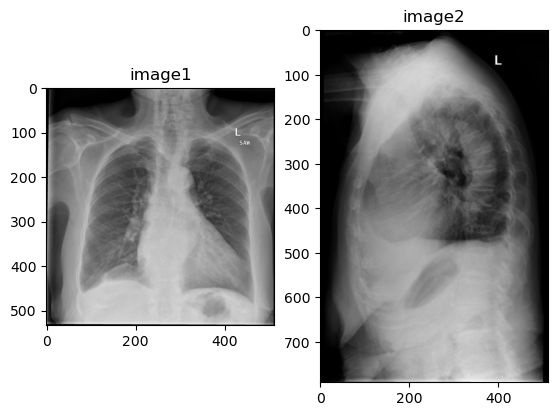

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR666_IM-2241-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR666_IM-2241-1002.png
blue:  (0.27145122541078787, 0.4955998647330268, 0.6081637999862947, 0.6696546139496112)
rouge:  0.2999999950500001
rouge_l:  0.28571428571428564
meteor:  0.13761467889908252
ACTUAL REPORT:  <sos> borderline cardiomegaly and mild chronic changes no acute infiltrate  <eos>
GENERATED REPORT:  <sos> stable cardiomegaly bibasilar atelectasis cardiomegaly without heart failure <eos> 
****************************************************************************************************


In [62]:
i=536
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 40ms/step


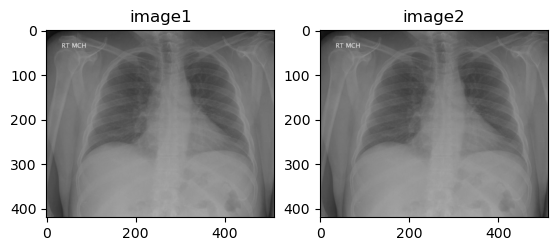

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1120_IM-0080-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1120_IM-0080-1001.png
blue:  (0.47768754038252614, 0.35826565528689464, 0.2999251749987234, 0.236682065782701)
rouge:  0.5999999952
rouge_l:  0.5714285714285715
meteor:  0.43684710351377026
ACTUAL REPORT:  <sos> limited low lung volume exam otherwise no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality no fracture visualized <eos> 
****************************************************************************************************


In [63]:
i=541
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 27ms/step


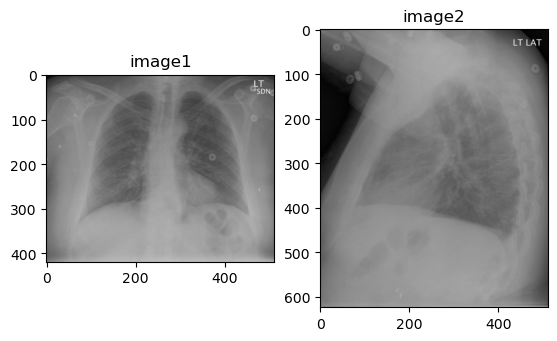

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-2001.png
blue:  (0.49713295378576094, 0.2358108650835347, 0.37109528395476105, 0.45936133207830593)
rouge:  0.4444444395061729
rouge_l:  0.4210526315789474
meteor:  0.3757575757575758
ACTUAL REPORT:  <sos> low lung volumes without evidence acute cardiopulmonary process  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality no evidence tuberculosis <eos> 
****************************************************************************************************


In [64]:
i=562
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


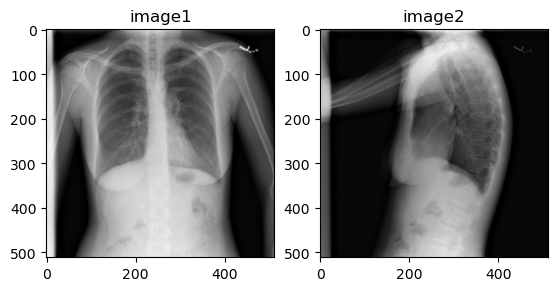

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-2001.png
blue:  (0.05450635860680253, 0.1218799230507912, 0.16023488466342664, 0.18225299438933673)
rouge:  0.12903225394380866
rouge_l:  0.12121212121212122
meteor:  0.046082949308755755
ACTUAL REPORT:  <sos> buckling deformity the anterior cortex the body fracture possible high energy was localized this region correlate with focal tenderness chest warranted  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [65]:
i=451
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 25ms/step


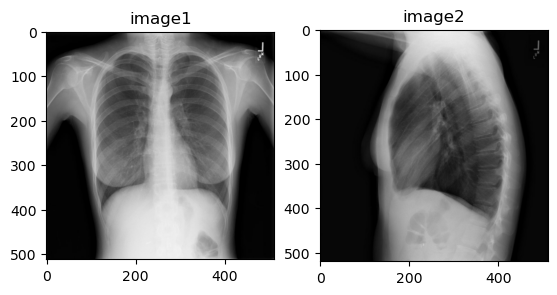

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-2001.png
blue:  (0.5, 0.3333333333333333, 0.24382614716244752, 0.34329452398451965)
rouge:  0.6666666618666668
rouge_l:  0.625
meteor:  0.46875
ACTUAL REPORT:  <sos> no acute pulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [66]:
i=1
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 36ms/step


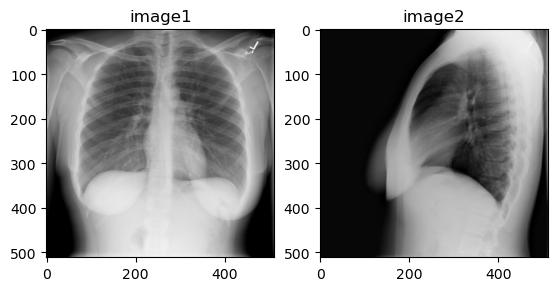

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-2001.png
blue:  (0.08075860719786215, 0.1276905697040564, 0.14921367476097985, 0.16056239100113953)
rouge:  0.17647058408304508
rouge_l:  0.16666666666666669
meteor:  0.08196721311475409
ACTUAL REPORT:  <sos> the heart size and cardiomediastinal silhouette are within normal limits pulmonary vasculature appears normal there no focal air space consolidation no pleural effusion pneumothorax  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities are seen end report <eos> 
****************************************************************************************************


In [67]:
i=136
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


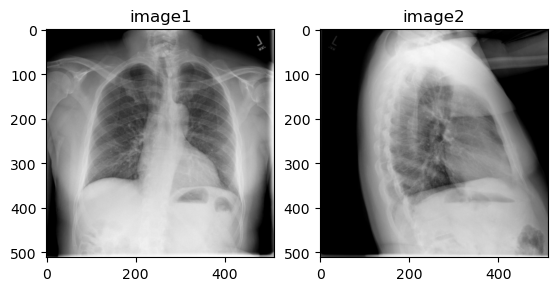

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-2001.png
blue:  (0.5, 0.3779644730092272, 0.29129144784395894, 0.392814650900513)
rouge:  0.5714285665306124
rouge_l:  0.5714285714285715
meteor:  0.6048387096774195
ACTUAL REPORT:  <sos> no acute cardiopulmonary disease  <eos>
GENERATED REPORT:  <sos> no acute pulmonary abnormality mild cardiomegaly <eos> 
****************************************************************************************************


In [68]:
i=12
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


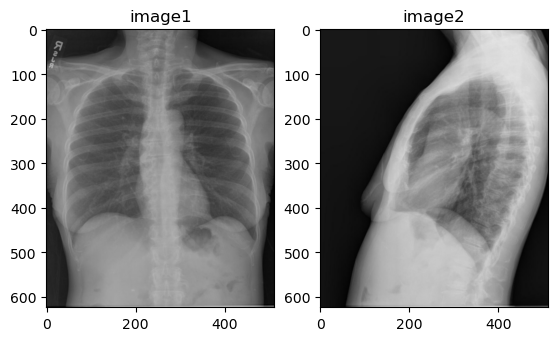

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.38461538461538464, 0.31008683647302115, 0.2630627225467731, 0.2044800736021839)
rouge:  0.5555555508024692
rouge_l:  0.5
meteor:  0.48947368421052634
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary disease no evidence for metastatic disease radiographic evaluation <eos> 
****************************************************************************************************


In [69]:
i=145
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


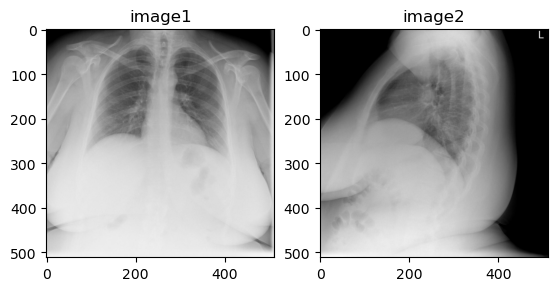

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-2001.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.63287829698514, 0.537284965911771)
rouge:  0.8333333283333335
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


In [70]:
i=179
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 38ms/step


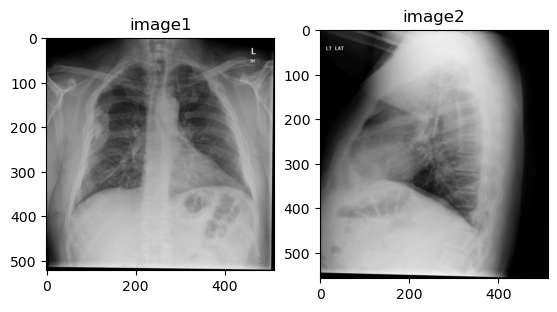

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1002.png
blue:  (0.5, 0.408248290463863, 0.350372724490772, 0.2777619034011791)
rouge:  0.6666666618666668
rouge_l:  0.7499999999999999
meteor:  0.7986111111111112
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [71]:
i=180
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


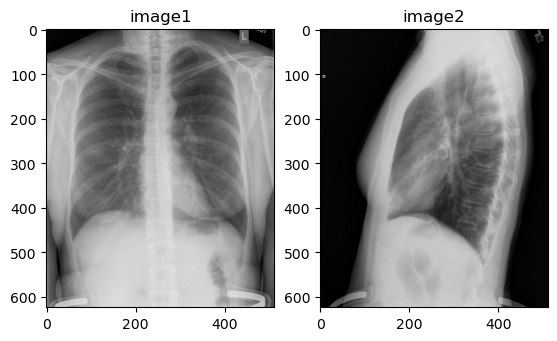

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-3003.png
blue:  (0.18393972058572117, 0.12262648039048077, 0.08969862676110706, 0.1262909976406414)
rouge:  0.34482758192627827
rouge_l:  0.4
meteor:  0.2690058479532163
ACTUAL REPORT:  <sos> comparison well expanded and clear lungs mediastinal contour within normal limits no acute cardiopulmonary abnormality identified stable chest  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [72]:
i=181
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


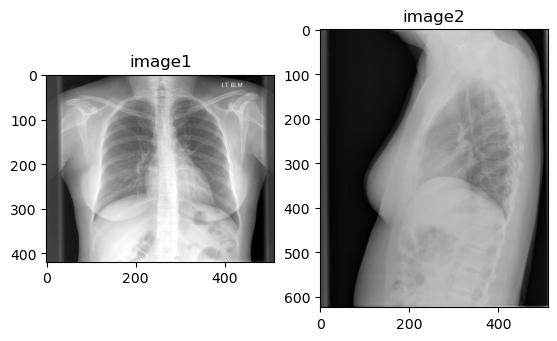

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-2001.png
blue:  (0.3333333333333333, 0.20412414523193154, 0.350372724490772, 0.45180100180492244)
rouge:  0.4285714239795918
rouge_l:  0.42857142857142855
meteor:  0.4732510288065844
ACTUAL REPORT:  <sos> no active disease  <eos>
GENERATED REPORT:  <sos> no evidence acute cardiopulmonary process interval cabg <eos> 
****************************************************************************************************


In [73]:
i=182
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


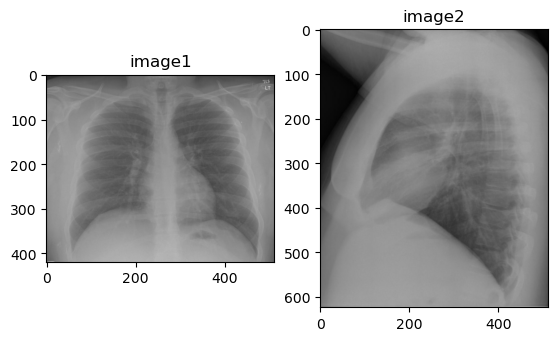

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-2001.png
blue:  (0.36363636363636365, 0.19069251784911848, 0.3349810280183093, 0.43668354428478123)
rouge:  0.470588230449827
rouge_l:  0.4444444444444444
meteor:  0.4265202702702703
ACTUAL REPORT:  <sos> negative for acute cardiopulmonary findings  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no radiographic evidence metastatic disease <eos> 
****************************************************************************************************


In [74]:
i=188
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 35ms/step


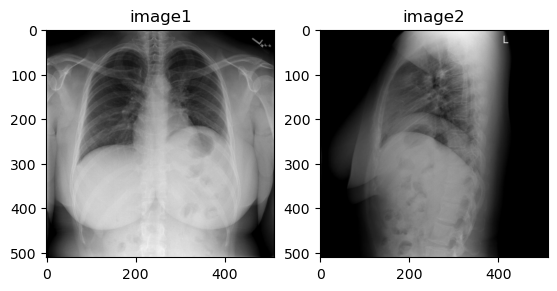

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-2001.png
blue:  (0.008520511068835796, 0.0147579580776766, 0.017788399957119984, 0.019422565110272495)
rouge:  0.12121211823691468
rouge_l:  0.11764705882352941
meteor:  0.03875968992248062
ACTUAL REPORT:  <sos> stable appearance chest without active process evident and without evidence progression disease patient with history hodgkin lymphoma one would like discuss this case further please thanks  <eos>
GENERATED REPORT:  <sos> right lower lobe pneumonia <eos> 
****************************************************************************************************


In [75]:
i=481
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

In [76]:
distinct_count = df['Result'].nunique()

# Print the distinct count
print("Distinct Result count :", distinct_count)

Distinct Result count : 121


In [77]:
distinct_count = df['Actual'].nunique()

# Print the distinct count
print("Distinct Result count :", distinct_count)

Distinct Result count : 391


In [78]:
import os
os.makedirs('/kaggle/output/', exist_ok=True)

In [79]:
import shutil

In [80]:
output_file_path = "/kaggle/working/impression_att_802022512.h5"
destination_dir = "/kaggle/output/"
shutil.copy(output_file_path, destination_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/impression_att_802022512.h5'

In [81]:
output_file_path = "/kaggle/working/results.csv"
destination_dir = "/kaggle/output/"
shutil.copy(output_file_path, destination_dir)

'/kaggle/output/results.csv'

1/1 [==============================] - 0s 24ms/step


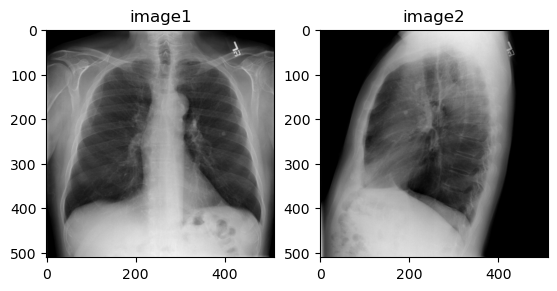

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2163_IM-0779-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2163_IM-0779-2001.png
blue:  (0.2645899562080751, 0.12753214818717798, 0.22486866269043357, 0.29365620234690254)
rouge:  0.26923076434911253
rouge_l:  0.2545454545454546
meteor:  0.22130919772934776
ACTUAL REPORT:  <sos> no suspicious pulmonary mass nodule identified however given the presence small nodules the chest ct scan and patient history prostate cancer recommend further evaluation with scan unless already recently performed  <eos>
GENERATED REPORT:  <sos> no acute pulmonary abnormality right apical nodule further evaluation chest should considered exclude the possibility pulmonary malignancy chronic findings discussed below <eos> 
****************************************************************************************************


In [82]:
i=504
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 21ms/step


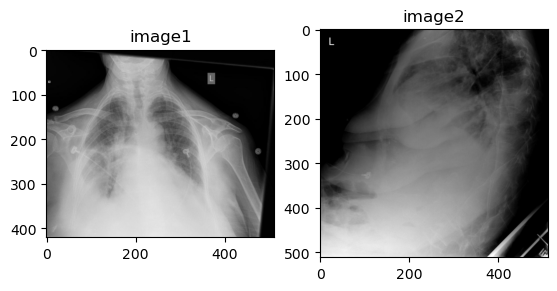

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1102_IM-0069-12012.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1102_IM-0069-2001.png
blue:  (0.5217391304347826, 0.37721676807715887, 0.24185640022402696, 0.341191474032336)
rouge:  0.5714285664399092
rouge_l:  0.5581395348837209
meteor:  0.5541871921182265
ACTUAL REPORT:  <sos> cardiomegaly vascular congestion and probable mild interstitial edema bibasilar airspace disease bilateral pleural effusions right greater than left  <eos>
GENERATED REPORT:  <sos> cardiomegaly with central vascular congestion and increased interstitial opacities suggesting mild interstitial pulmonary edema small bilateral pleural effusions no visible pneumothorax <eos> 
****************************************************************************************************


In [83]:
i=681
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 23ms/step


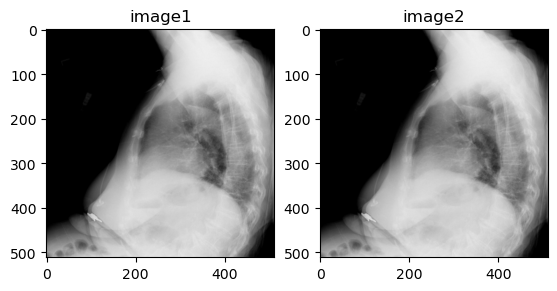

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2582_IM-1080-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2582_IM-1080-1001.png
blue:  (0.5454545454545454, 0.4670993664969138, 0.42107563243008606, 0.3672056269893592)
rouge:  0.5714285664399092
rouge_l:  0.5714285714285713
meteor:  0.5830583058305829
ACTUAL REPORT:  <sos> low lung volumes with no definite acute findings  <eos>
GENERATED REPORT:  <sos> low lung volumes with blunted costophrenic bilateral pleural effusions <eos> 
****************************************************************************************************


In [84]:
i=656
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 26ms/step


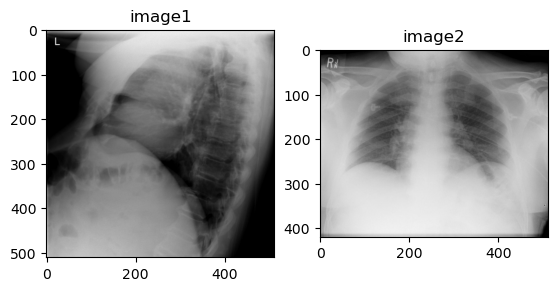

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1050_IM-0038-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1050_IM-0038-4004.png
blue:  (0.3478260869565218, 0.25147784538477264, 0.2115667765139312, 0.17337056134697476)
rouge:  0.3999999951125
rouge_l:  0.45
meteor:  0.5068181818181818
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality mild nonspecific prominence mediastinum consider repeat any concern for vascular process  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality prominent soft tissue density the upper mediastinum recommend follow and lateral radiograph ct thorax for further evaluation <eos> 
****************************************************************************************************


In [85]:
i=530
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 32ms/step


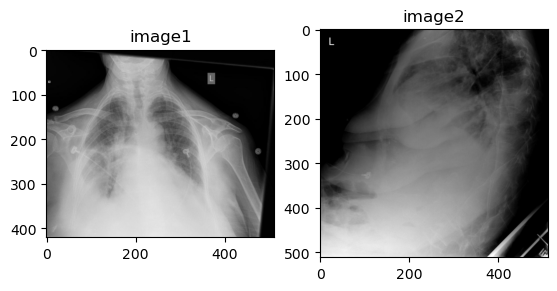

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1102_IM-0069-12012.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1102_IM-0069-2001.png
blue:  (0.5217391304347826, 0.37721676807715887, 0.24185640022402696, 0.341191474032336)
rouge:  0.5714285664399092
rouge_l:  0.5581395348837209
meteor:  0.5541871921182265
ACTUAL REPORT:  <sos> cardiomegaly vascular congestion and probable mild interstitial edema bibasilar airspace disease bilateral pleural effusions right greater than left  <eos>
GENERATED REPORT:  <sos> cardiomegaly with central vascular congestion and increased interstitial opacities suggesting mild interstitial pulmonary edema small bilateral pleural effusions no visible pneumothorax <eos> 
****************************************************************************************************


In [86]:
i=681
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


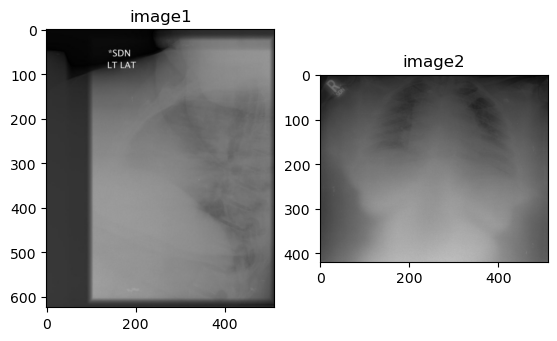

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1961_IM-0628-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1961_IM-0628-3001.png
blue:  (0.21739130434782608, 0.46625240412015684, 0.6043519330306506, 0.6828267746069693)
rouge:  0.21052631091412755
rouge_l:  0.20512820512820512
meteor:  0.17964071856287422
ACTUAL REPORT:  <sos> limited examination with stable cardiomegaly and low lung volumes without acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  <sos> cardiomegaly with central vascular congestion and increased interstitial opacities suggesting mild interstitial pulmonary edema small bilateral pleural effusions no visible pneumothorax <eos> 
****************************************************************************************************


In [87]:
i=715
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 32ms/step


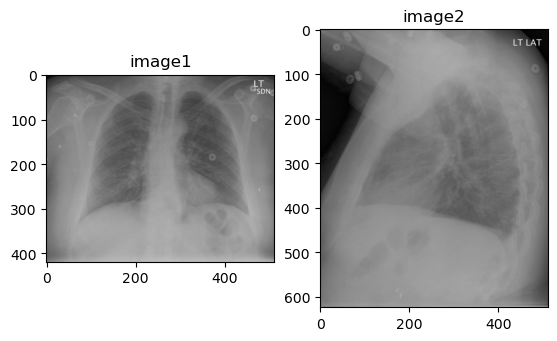

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-2001.png
blue:  (0.49713295378576094, 0.2358108650835347, 0.37109528395476105, 0.45936133207830593)
rouge:  0.4444444395061729
rouge_l:  0.4210526315789474
meteor:  0.3757575757575758
ACTUAL REPORT:  <sos> low lung volumes without evidence acute cardiopulmonary process  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality no evidence tuberculosis <eos> 
****************************************************************************************************


In [88]:
i=562
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


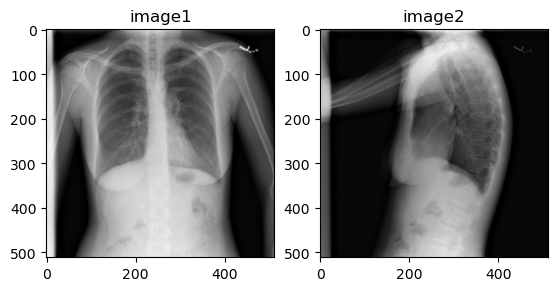

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-2001.png
blue:  (0.05450635860680253, 0.1218799230507912, 0.16023488466342664, 0.18225299438933673)
rouge:  0.12903225394380866
rouge_l:  0.12121212121212122
meteor:  0.046082949308755755
ACTUAL REPORT:  <sos> buckling deformity the anterior cortex the body fracture possible high energy was localized this region correlate with focal tenderness chest warranted  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [89]:
i=451
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


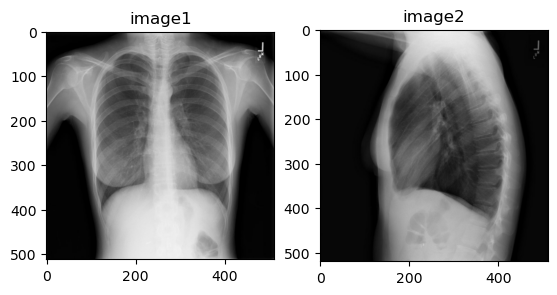

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-2001.png
blue:  (0.5, 0.3333333333333333, 0.24382614716244752, 0.34329452398451965)
rouge:  0.6666666618666668
rouge_l:  0.625
meteor:  0.46875
ACTUAL REPORT:  <sos> no acute pulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [90]:
i=1
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 34ms/step


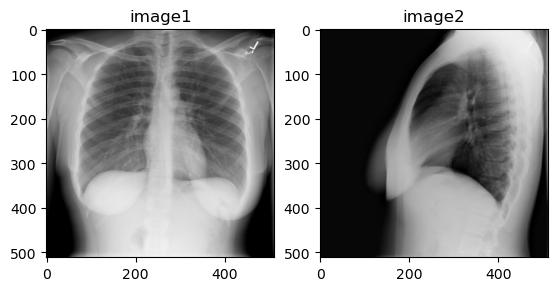

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-2001.png
blue:  (0.08075860719786215, 0.1276905697040564, 0.14921367476097985, 0.16056239100113953)
rouge:  0.17647058408304508
rouge_l:  0.16666666666666669
meteor:  0.08196721311475409
ACTUAL REPORT:  <sos> the heart size and cardiomediastinal silhouette are within normal limits pulmonary vasculature appears normal there no focal air space consolidation no pleural effusion pneumothorax  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities are seen end report <eos> 
****************************************************************************************************


In [91]:
i=136
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


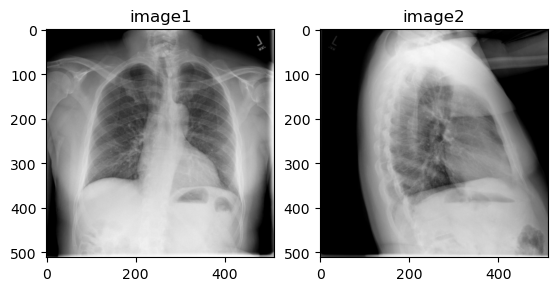

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-2001.png
blue:  (0.5, 0.3779644730092272, 0.29129144784395894, 0.392814650900513)
rouge:  0.5714285665306124
rouge_l:  0.5714285714285715
meteor:  0.6048387096774195
ACTUAL REPORT:  <sos> no acute cardiopulmonary disease  <eos>
GENERATED REPORT:  <sos> no acute pulmonary abnormality mild cardiomegaly <eos> 
****************************************************************************************************


In [92]:
i=12
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 25ms/step


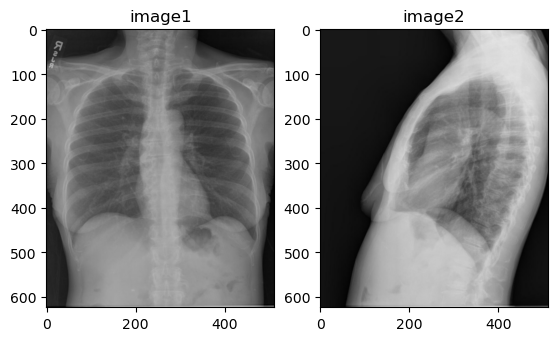

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.38461538461538464, 0.31008683647302115, 0.2630627225467731, 0.2044800736021839)
rouge:  0.5555555508024692
rouge_l:  0.5
meteor:  0.48947368421052634
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary disease no evidence for metastatic disease radiographic evaluation <eos> 
****************************************************************************************************


In [93]:
i=145
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


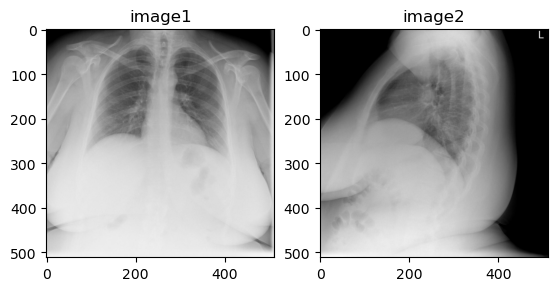

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-2001.png
blue:  (0.8333333333333334, 0.7071067811865476, 0.63287829698514, 0.537284965911771)
rouge:  0.8333333283333335
rouge_l:  1.0
meteor:  0.9976851851851852
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality <eos> 
****************************************************************************************************


In [94]:
i=179
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 25ms/step


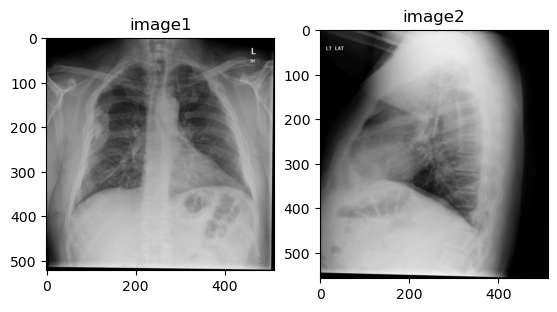

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1002.png
blue:  (0.5, 0.408248290463863, 0.350372724490772, 0.2777619034011791)
rouge:  0.6666666618666668
rouge_l:  0.7499999999999999
meteor:  0.7986111111111112
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [95]:
i=180
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


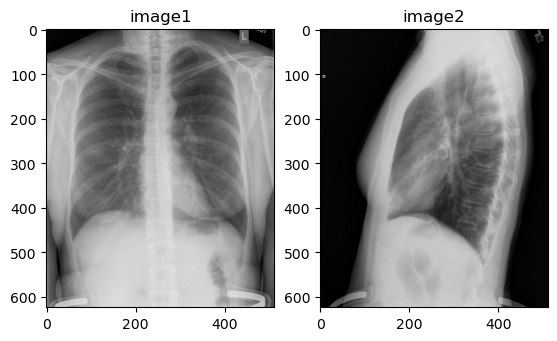

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-3003.png
blue:  (0.18393972058572117, 0.12262648039048077, 0.08969862676110706, 0.1262909976406414)
rouge:  0.34482758192627827
rouge_l:  0.4
meteor:  0.2690058479532163
ACTUAL REPORT:  <sos> comparison well expanded and clear lungs mediastinal contour within normal limits no acute cardiopulmonary abnormality identified stable chest  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no active pulmonary disease <eos> 
****************************************************************************************************


In [96]:
i=181
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


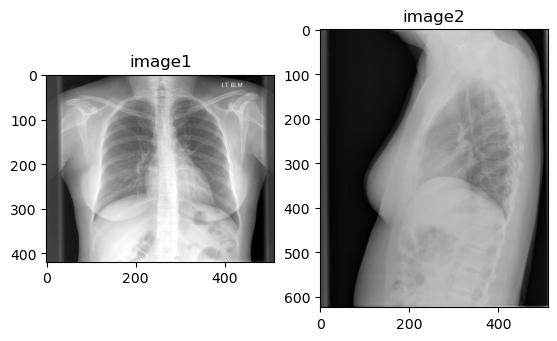

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-2001.png
blue:  (0.3333333333333333, 0.20412414523193154, 0.350372724490772, 0.45180100180492244)
rouge:  0.4285714239795918
rouge_l:  0.42857142857142855
meteor:  0.4732510288065844
ACTUAL REPORT:  <sos> no active disease  <eos>
GENERATED REPORT:  <sos> no evidence acute cardiopulmonary process interval cabg <eos> 
****************************************************************************************************


In [97]:
i=182
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 32ms/step


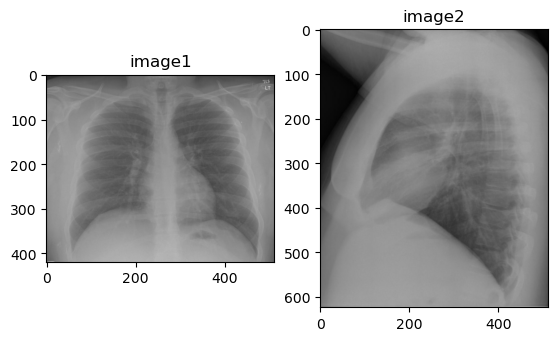

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-2001.png
blue:  (0.36363636363636365, 0.19069251784911848, 0.3349810280183093, 0.43668354428478123)
rouge:  0.470588230449827
rouge_l:  0.4444444444444444
meteor:  0.4265202702702703
ACTUAL REPORT:  <sos> negative for acute cardiopulmonary findings  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormalities no radiographic evidence metastatic disease <eos> 
****************************************************************************************************


In [98]:
i=188
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 24ms/step


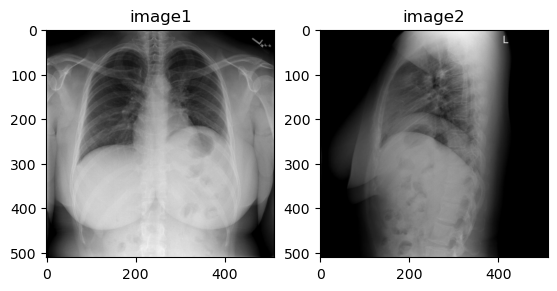

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-2001.png
blue:  (0.008520511068835796, 0.0147579580776766, 0.017788399957119984, 0.019422565110272495)
rouge:  0.12121211823691468
rouge_l:  0.11764705882352941
meteor:  0.03875968992248062
ACTUAL REPORT:  <sos> stable appearance chest without active process evident and without evidence progression disease patient with history hodgkin lymphoma one would like discuss this case further please thanks  <eos>
GENERATED REPORT:  <sos> right lower lobe pneumonia <eos> 
****************************************************************************************************


In [99]:
i=481
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)